In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers.core import Flatten, Dense, Activation, Reshape


Using TensorFlow backend.


In [6]:
IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = 20
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.55#0.5
NMS_THRESHOLD    = 0.45#0.45
ANCHORS          = [1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52]


In [2]:
keras.backend.set_image_dim_ordering('tf')

def yolo_v2():
    ## layer 1
    model = Sequential()
    model.add(Conv2D(16, (3, 3),input_shape=(416,416,3),strides=(1,1),name='conv_1',padding='same',use_bias=False))
    model.add(BatchNormalization(name='norm_1'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    ## layer2
    model.add(Conv2D(32,(3,3) ,strides=(1,1),name='conv_2',padding='same',use_bias=False))
    model.add(BatchNormalization(name='norm_2'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

    ## layer3
    model.add(Conv2D(64,(3,3),strides=(1,1),name='conv_3',padding='same',use_bias=False))
    model.add(BatchNormalization(name='norm_3'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

    ## layer4
    model.add(Conv2D(128,(3,3),strides=(1,1),name='conv_4',padding='same',use_bias=False))
    model.add(BatchNormalization(name='norm_4'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

    ## layer5
    model.add(Conv2D(256,(3,3),strides=(1,1),name='conv_5',padding='same',use_bias=False))
    model.add(BatchNormalization(name='norm_5'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

    ## layer6
    model.add(Conv2D(512,(3,3),strides=(1,1), name='conv_6' ,padding='same',use_bias=False))
    model.add(BatchNormalization(name='norm_6'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1,1),padding='same'))

    ## layer7
    model.add(Conv2D(1024,(3,3),strides=(1,1),name='conv_7' ,padding='same',use_bias=False))
    model.add(BatchNormalization(name='norm_7'))
    model.add(LeakyReLU(alpha=0.1))

    ## layer8
    model.add(Conv2D(1024,(3,3),strides=(1,1),name='conv_8' , padding='same',use_bias=False))
    model.add(BatchNormalization(name='norm_8'))
    model.add(LeakyReLU(alpha=0.1))

    ## layer9
    model.add(Conv2D(125,(1,1),strides=(1,1),name='conv_9' , padding='same'))    
    return (model)


In [3]:
model_yolo2= yolo_v2()
model_yolo2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 416, 416, 16)      432       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 208, 208, 32)      4608      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 208, 208, 32)      128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 208, 208, 32)      0         
__________

In [5]:
class WeightReader:
    """ An object to read the weights file"""
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        """Read bytes from the file"""
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        """Reset the index"""
        self.offset = 4
        
class BoundBox:
    """An object to build the bound box for object detection"""
    def __init__(self, x, y, w, h, c = None, classes = None):
        self.x     = x
        self.y     = y
        self.w     = w
        self.h     = h
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        """Retrieves the confidence score for the class"""
        if self.score == -1:
            self.score = self.classes
            
        return self.score


def decode_netout(netout, obj_threshold, nms_threshold, anchors, nb_class):
    """Returns bounding boxes for each class"""
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                classes = classes[6]
                #print(classes)
                if np.sum(classes) > 0:
                    #print (classes)
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x, y, w, h, confidence, classes)
                    
                    boxes.append(box)

    
    
    # suppress non-maximal boxes
    

    sorted_indices = list(reversed(np.argsort([box.classes for box in boxes])))

    for i in range(len(sorted_indices)):
        index_i = sorted_indices[i]

        if boxes[index_i].classes == 0: 
            continue
        else:
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                    boxes[index_j].classes = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes

def sigmoid(x):
    """Computes sigmoid """
    return 1. / (1. + np.exp(-x))

def softmax(x, axis=-1, t=-100.):
    """Computes softmax"""
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

def bbox_iou(box1, box2):
    """Computes Intersection over union for boxes"""
    x1_min  = box1.x - box1.w/2
    x1_max  = box1.x + box1.w/2
    y1_min  = box1.y - box1.h/2
    y1_max  = box1.y + box1.h/2
    
    x2_min  = box2.x - box2.w/2
    x2_max  = box2.x + box2.w/2
    y2_min  = box2.y - box2.h/2
    y2_max  = box2.y + box2.h/2
    
    intersect_w = interval_overlap([x1_min, x1_max], [x2_min, x2_max])
    intersect_h = interval_overlap([y1_min, y1_max], [y2_min, y2_max])
    
    intersect = intersect_w * intersect_h
    
    union = box1.w * box1.h + box2.w * box2.h - intersect
    
    return float(intersect) / union

def interval_overlap(interval_a, interval_b):
    """Calculates overlap between the image"""
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3 
        

        


def draw_box_v2(boxes,im,crop_dim):
    """It is used to draw boxes around the object"""
    imgcv = im
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    c=0
    for b in boxes:
        
        c+=1
        h, w, _ = imgcv.shape
        left  = int ((b.x - b.w/2.) * w)
        right = int ((b.x + b.w/2.) * w)
        top   = int ((b.y - b.h/2.) * h)
        bot   = int ((b.y + b.h/2.) * h)
        #print(left)
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)
        #print(left)
        
        
        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(imgcv, (left, top), (right, bot), (255,0,0), thick)

    return imgcv
        

In [7]:
wt_path = 'weights/tiny-yolo-voc.weights'
weight_reader = WeightReader(wt_path)
weight_reader.reset()

len(np.fromfile(wt_path, dtype='float32'))

15867889

In [8]:
#Set weights for each layer
nb_conv = 9

for i in range(1, nb_conv+1):
    print (i)
    conv_layer = model_yolo2.get_layer('conv_' + str(i))

    if i < nb_conv:
        norm_layer = model_yolo2.get_layer('norm_' + str(i))
        print('norm_layer')
        #prinorm_laynt (len(norm_layer.get_weights()))
        [print(w.shape) for w in norm_layer.get_weights()]
        size = np.prod(norm_layer.get_weights()[0].shape)
        print(size)
        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        print (conv_layer)
        print(conv_layer.get_weights()[0].shape)
        kshape=conv_layer.get_weights()[0].shape
        if(len(kshape) == 4):
            kshape = (kshape[3], kshape[2], kshape[0], kshape[1])

        #print(list(reversed(conv_layer.get_weights()[0].shape)))
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        print(kernel.shape)
        #kernel = kernel.reshape([3,2,0,1])
        kernel = kernel.reshape(kshape)
        kernel = kernel.transpose([2,3,1,0])
        #print(kernel)
        conv_layer.set_weights([kernel, bias])
    else:
        print (conv_layer)
        print(conv_layer.get_weights()[0].shape)
        kshape=conv_layer.get_weights()[0].shape
        if(len(kshape) == 4):
            kshape = (kshape[3], kshape[2], kshape[0], kshape[1])
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        #kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        #print(kernel.shape)
        kernel = kernel.reshape(kshape)
        kernel = kernel.transpose([2,3,1,0])
        #print(kernel)
        conv_layer.set_weights([kernel])


1
norm_layer
(16,)
(16,)
(16,)
(16,)
16
(3, 3, 3, 16)
2
norm_layer
(32,)
(32,)
(32,)
(32,)
32
(3, 3, 16, 32)
3
norm_layer
(64,)
(64,)
(64,)
(64,)
64
(3, 3, 32, 64)
4
norm_layer
(128,)
(128,)
(128,)
(128,)
128
(3, 3, 64, 128)
5
norm_layer
(256,)
(256,)
(256,)
(256,)
256
(3, 3, 128, 256)
6
norm_layer
(512,)
(512,)
(512,)
(512,)
512
(3, 3, 256, 512)
7
norm_layer
(1024,)
(1024,)
(1024,)
(1024,)
1024
(3, 3, 512, 1024)
8
norm_layer
(1024,)
(1024,)
(1024,)
(1024,)
1024
(3, 3, 1024, 1024)
9
(1, 1, 1024, 125)
(128000,)


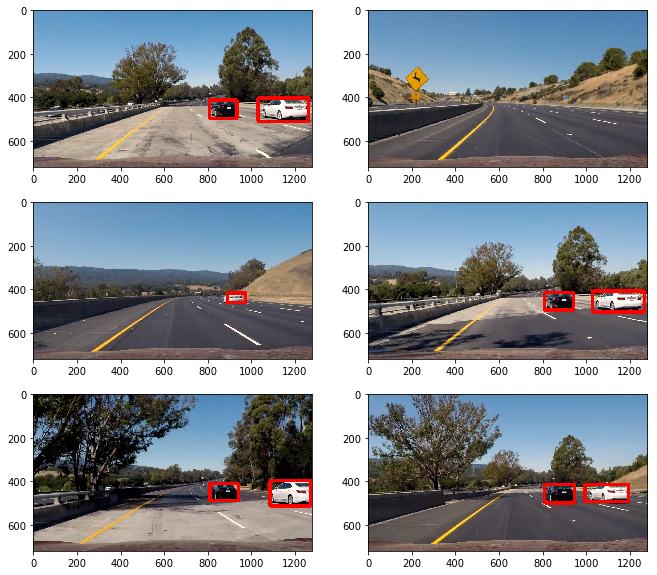

In [9]:
import glob

images = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([cv2.resize(image[300:650,500:,:],(416,416)) for image in images])

batch = batch/255.

out = model_yolo2.predict(batch)

f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    #print(out[i].shape)
    output = np.reshape(out[i],(GRID_H,  GRID_W ,BOX,4+1+CLASS))
    boxes = decode_netout(output, 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
    ax.imshow(draw_box_v2(boxes,images[i],[[500,1280],[300,650]]))

plt.show()

In [ ]:
## Create a video pipeline
## Run this function on the GPU to get much faster fps.
def frame_func(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(416,416))
    #batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = resized/255
    batch = np.expand_dims(batch, 0)
    out = model_yolo2.predict(batch)
    output =  np.reshape(out[0],(13,13,5,25))
    boxes = decode_netout(output, 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
    return draw_box_v2(boxes,image,[[500,1280],[300,650]])

project_video_output = './project_video_output_v2.mp4'
clip1 = VideoFileClip("./project_video.mp4")

lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)